In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim  
from util.model_evaluation import ModelEvaluator
from util.plot import plot_predictions, plot_valid_test_only_predictions
import random
from statsmodels.tsa.arima.model import ARIMA
import os
import json
from collections import deque

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


In [2]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
random.seed(229)
torch.cuda.empty_cache()


In [3]:
#### Load High-Frequency Data ####

data_path = "../data/btc_usdt_1m_2017_8_to_2023_12.csv"
data = pd.read_csv(data_path, dtype=str)

print("Column names:", data.columns)
features = ['high', 'low', 'open', 'close', 'volume']

df = data

# Convert 'timestamp' to datetime and round any fractional seconds
print("Original Timestamps (First 5):", data['timestamp'].head())
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce') // 1000
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
print("Converted Timestamps (First 5):", df['timestamp'].head())
df['timestamp'] = df['timestamp'].dt.round('1s')
df = df.drop_duplicates(subset=['timestamp'], keep='first').reset_index(drop=True)

# Ensure key data columns are numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Create Dollar-Weighted Volume
df["dollar_volume"] = df["volume"]*df["close"]
#aggregated["dollar_volume"] = aggregated["volume"]*average_prices
periods_per_30_days = 1*60*24*30
df['30_day_dollar_ADTV'] = df['dollar_volume'].rolling(window=periods_per_30_days, min_periods=1).mean() 
df['normalized_dollar_volume'] = df['dollar_volume'] / df['30_day_dollar_ADTV']

# Create a column for the 30-minute groupings based on the timestamp floor
df['time_group'] = df['timestamp'].dt.floor('60min')
#periods_per_day = 24*2

# Perform the aggregation within each 30-minute group
aggregated = df.groupby('time_group').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'normalized_dollar_volume': 'mean'
}).reset_index()

print(aggregated)

# Calculate percentage returns for each column in `features`
for col in features:
    aggregated[f'{col}_return'] = aggregated[col].pct_change()

# Drop rows with NaN values resulting from percentage change calculation
aggregated = aggregated.dropna().reset_index(drop=True)

# Clip the returns at ±10% for each feature
for col in features:
    aggregated[f'{col}_return'] = aggregated[f'{col}_return'].clip(lower=-0.1, upper=0.1)

# Select only the return columns in the order of `features`
return_features = [f'{col}_return' for col in features]
features = ['high_return', 'low_return', 'open_return', 'close_return']
aggregated_returns = aggregated[return_features]

# print("Aggregated Data with Returns:")
# print(aggregated)

# Optional: View the final returns-only DataFrame if you need it
# print("Aggregated Returns-Only DataFrame:")
# print(aggregated_returns)

# Delete the original 1-minute data DataFrame to free up memory
del data, df

# Assign the final processed close column for potential further use
btc_close = aggregated['close']
btc_close_pct = aggregated['close_return']

Column names: Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume',
       'taker_buy_quote_volume'],
      dtype='object')
Original Timestamps (First 5): 0    1502942400000
1    1502942460000
2    1502942520000
3    1502942580000
4    1502942640000
Name: timestamp, dtype: object
Converted Timestamps (First 5): 0   2017-08-17 04:00:00+00:00
1   2017-08-17 04:01:00+00:00
2   2017-08-17 04:02:00+00:00
3   2017-08-17 04:03:00+00:00
4   2017-08-17 04:04:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
                     time_group      open      high       low     close  \
0     2017-08-17 04:00:00+00:00   4261.48   4313.62   4261.32   4308.83   
1     2017-08-17 05:00:00+00:00   4308.83   4328.69   4291.37   4315.32   
2     2017-08-17 06:00:00+00:00   4315.32   4345.45   4309.37   4324.35   
3     2017-08-17 07:00:00+00:00   4324.35   4349.99   4287.41   4349.99   
4     2017-08-17 08:00

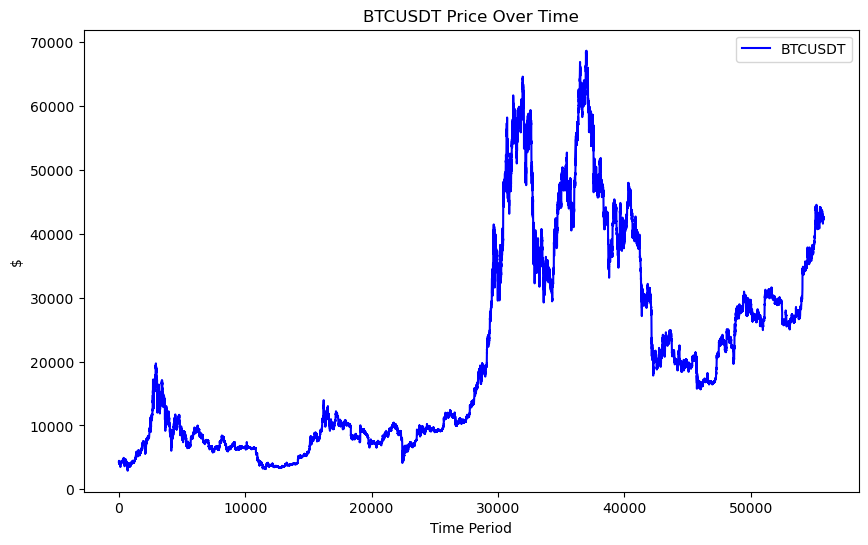

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(btc_close, label="BTCUSDT", color="blue")
plt.xlabel("Time Period")
plt.ylabel("$")
plt.title("BTCUSDT Price Over Time")
plt.legend()
plt.grid(False)
plt.show()

In [5]:
# Step 3: Update the sequence creation function to use unscaled percentage changes and scaled volumes
def create_windowed_sequences(data, window_size, forecast_horizon=5):
    sequences = []
    targets = []
    data_array = data[['open_return', 'high_return', 'low_return', 'close_return','normalized_dollar_volume']].values
    for i in range(len(data_array) - window_size - forecast_horizon + 1):
        sequence = data_array[i:i+window_size]
        target = data_array[i + window_size:i + window_size + forecast_horizon]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def create_windowed_sequences_levels(data, window_size, forecast_horizon=5):
    sequences = []
    targets = []
    data_array = data[['open', 'high', 'low', 'close','normalized_dollar_volume']].values
    for i in range(len(data_array) - window_size - forecast_horizon + 1):
        sequence = data_array[i:i+window_size]
        target = data_array[i + window_size:i + window_size + forecast_horizon]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [6]:
def window_series_multivariate(series_df, input_window=100, forecast_window=30, n_windows0=10000):
    n_periods = series_df.shape[0]
    n_features = series_df.shape[1]
    window_length = input_window + forecast_window
    n_windows = min(n_periods - window_length + 1, n_windows0)
    
    # Initialize the window array for multivariate series
    window_array = np.zeros((window_length, n_windows, n_features))
    
    for w in range(n_windows):
        window = series_df.iloc[w:(w + window_length)].values
        window_array[:, w, :] = window

    # Separate into input and forecast data
    input_data = window_array[0:input_window, :, :]
    forecast_data = window_array[input_window:, :, :]
    
    return input_data, forecast_data

In [7]:
# Set parameters
window_size = 1*24*20 # per-hour*hours-per-day*days
forecast_horizon = 1*24*1 # 1 day

variables = ['open_return', 'high_return', 'low_return', 'close_return','normalized_dollar_volume']
variables_levels = ['open', 'high', 'low', 'close','normalized_dollar_volume']
df_model = aggregated[variables]
df_model_levels = aggregated[variables_levels]
print("Getting X, y")
X, y = create_windowed_sequences(df_model, window_size, forecast_horizon = forecast_horizon)
print("Getting X_prices, y_prices")
X_prices, y_prices = create_windowed_sequences_levels(df_model_levels, window_size, forecast_horizon = forecast_horizon)

#X_pm, y_pm = window_series_multivariate(df_model, window_size, forecast_window = forecast_horizon, n_windows0 = 160000)


Getting X, y
Getting X_prices, y_prices


In [8]:
print(df_model.shape)
print(X.shape)
print(y.shape)
#print(X_pm.shape)
#print(y_pm.shape)
print(X_prices.shape)
print(y_prices.shape)

(55740, 5)
(55237, 480, 5)
(55237, 24, 5)
(55237, 480, 5)
(55237, 24, 5)


In [9]:
def run_arima_windows_univariate(data_train, data_forecast_actuals, p=0, d=0, q=0, trend=None, horizon=30):
    """
    Function to run ARIMA model on a univariate time series data window.
    If p = d = q = 0, forecasts are based on a random walk without drift.

    Parameters:
    - data_train: 2D numpy array, shape (input_window, n_windows) for the training data windows.
    - data_forecast_actuals: 2D numpy array, shape (forecast_window, n_windows) for the actual future data.
    - p, d, q: ARIMA model order parameters.
    - trend: Trend parameter for ARIMA model. For a random walk with drift, use 'c' (constant).
    - horizon: Forecast horizon, i.e., number of steps to forecast.

    Returns:
    - forecast_matrix: 2D numpy array with forecasts, shape (horizon, n_windows).
    - model_accuracy_table: DataFrame with accuracy metrics for each horizon step.
    """
    n_windows = data_train.shape[0]
    
    # Initialize forecast and error matrices
    forecast_matrix = np.full((horizon, n_windows), np.nan)
    error_matrix = np.full((horizon, n_windows), np.nan)
    
    if p == 0 and d == 0 and q == 0 and trend == None:
        # If p=d=q=0, we have a random walk (no drift).
        # Simply predict the last value in each training window for all forecast steps.
        forecast_matrix[:] = 0  # Set all forecast steps to 0 growth in RW no Drift
    else:
        # Run ARIMA model for each window
        for w in range(n_windows):
            model = ARIMA(data_train[w, :], order=(p, d, q), trend=trend)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=horizon)
            forecast_matrix[:, w] = forecast
            if w % 20 == 0:
                print(f"Window: {w} / {n_windows}")

    # Compute errors
    data_forecast_actuals_transpose = data_forecast_actuals.T
    error_matrix = forecast_matrix - data_forecast_actuals_transpose
    


    # Calculate accuracy metrics
    accuracy_matrix = np.zeros((6, horizon))

    for h in range(horizon):
        # Errors at step h
        horizon_errors = error_matrix[h, :]
        actuals_at_horizon = data_forecast_actuals_transpose[h, :]
        
        # Compute accuracy metrics for the unnormalized errors
        accuracy_matrix[0, h] = np.sqrt(np.mean(horizon_errors**2))  # RMSE
        accuracy_matrix[1, h] = np.mean(horizon_errors**2)  # MSE
        accuracy_matrix[2, h] = np.mean(horizon_errors)  # ME
        accuracy_matrix[3, h] = np.mean(np.abs(horizon_errors / (actuals_at_horizon + 1e-8)))  # MAPE
        accuracy_matrix[4, h] = np.mean(horizon_errors / (actuals_at_horizon + 1e-8))  # MPE

        ss_res = np.sum(horizon_errors**2)  # Residual sum of squares
        ss_tot = np.sum((actuals_at_horizon - np.mean(actuals_at_horizon))**2)  # Total sum of squares
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0  # Handle edge case where ss_tot = 0
        accuracy_matrix[5, h] = r_squared

    # Create DataFrame for accuracy table
    model_accuracy_table = pd.DataFrame(
        accuracy_matrix.T, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
    )

    return forecast_matrix, model_accuracy_table

In [10]:
# Calculate exact split sizes
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15
total_size = len(X)

In [11]:
# First, calculate training and validation sizes
train_size = int(total_size * train_ratio)
valid_size = int(total_size * valid_ratio)
test_size = total_size - (train_size + valid_size)  # Assign remaining data to test to ensure total matches


In [12]:
# Apply the split
X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size + valid_size], y[train_size:train_size + valid_size]
X_test, y_test = X[train_size + valid_size:], y[train_size + valid_size:]

X_train_prices, y_train_prices = X_prices[:train_size], y_prices[:train_size]
X_valid_prices, y_valid_prices = X_prices[train_size:train_size + valid_size], y_prices[train_size:train_size + valid_size]
X_test_prices, y_test_prices = X_prices[train_size + valid_size:], y_prices[train_size + valid_size:]


In [13]:
combined_length = len(X_train) + len(X_valid) + len(X_test)
print(combined_length)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(X_test[:,:,3].shape)
print(y_test[:,:,3].shape)

55237
(38665, 480, 5)
(8285, 480, 5)
(8287, 480, 5)
(8287, 480)
(8287, 24)


In [14]:
forecast_matrix_RW_test, model_accuracy_table_RW_test = run_arima_windows_univariate(X_test[:,:,3],
                                                                              y_test[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)
forecast_matrix_RW_valid, model_accuracy_table_RW_valid = run_arima_windows_univariate(X_valid[:,:,3],
                                                                              y_valid[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)

In [15]:
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)

model_accuracy_table_RW_test.to_csv('model_accuracy_table_RW_test.csv', index=False)
np.save('forecast_matrix_RW_test.npy', forecast_matrix_RW_test)

model_accuracy_table_RW_test = pd.read_csv('model_accuracy_table_RW_test.csv', na_values=["inf", "NaN"])
forecast_matrix_RW_test = np.load('forecast_matrix_RW_test.npy')
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)



        RMSE       MSE        ME      MAPE       MPE       R^2
0   0.004540  0.000021 -0.000096  0.999874 -0.999874 -0.000445
1   0.004540  0.000021 -0.000095  0.999874 -0.999874 -0.000441
2   0.004540  0.000021 -0.000094  0.999874 -0.999874 -0.000432
3   0.004539  0.000021 -0.000094  0.999874 -0.999874 -0.000428
4   0.004539  0.000021 -0.000094  0.999874 -0.999874 -0.000429
5   0.004538  0.000021 -0.000095  0.999874 -0.999874 -0.000437
6   0.004538  0.000021 -0.000094  0.999874 -0.999874 -0.000432
7   0.004538  0.000021 -0.000095  0.999874 -0.999874 -0.000439
8   0.004538  0.000021 -0.000095  0.999874 -0.999874 -0.000438
9   0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000442
10  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000442
11  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000438
12  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000440
13  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000442
14  0.004539  0.000021 -0.000096  0.999874 -0.999874 -0

In [16]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)



In [17]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        x = self.fc(lstm_out[:, -1, :])
        return x.view(-1, forecast_horizon, input_dim)

In [18]:
# Hyperparameters
input_dim = 5
hidden_dim = 200
num_layers = 1
output_dim = forecast_horizon * 5
num_epochs = 100
batch_size = 20 # 32
learning_rate = 0.0001 # 0.001
dropout_rate = 0.2
patience = 5


In [19]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

In [22]:
# Perform Hyper Parameter Search Based on Validation Loss for Closing Price Validation Loss --- With GAMMA

# Make a Discounted SmoothL1Loss Function:
class DiscountedSmoothL1Loss(nn.Module):
    def __init__(self, gamma=0.9, beta=1.0):
        """
        Initializes the DiscountedSmoothL1Loss module.
        Args:
            gamma (float): Initial discount rate for the forecast horizon.
            beta (float): Transition point for SmoothL1Loss.
        """
        super(DiscountedSmoothL1Loss, self).__init__()
        self.gamma = gamma
        self.beta = beta

    def set_gamma(self, gamma):
        """
        Update the discount rate gamma dynamically.
        Args:
            gamma (float): New discount rate.
        """
        self.gamma = gamma

    def forward(self, predictions, targets):
        """
        Compute the discounted SmoothL1Loss.
        Args:
            predictions (torch.Tensor): Predicted values of shape (batch_size, horizon, *dims).
            targets (torch.Tensor): True values of shape (batch_size, horizon, *dims).
        Returns:
            torch.Tensor: Discounted SmoothL1 loss.
        """
        horizon = predictions.size(1)  # Assumes shape (batch_size, horizon, ...)
        
        # Compute absolute difference
        diff = torch.abs(predictions - targets)

        # Compute SmoothL1 loss for each forecast step
        loss = torch.where(
            diff < self.beta,
            0.5 * (diff**2) / self.beta,
            diff - 0.5 * self.beta
        )

        # Apply discount factors
        discount_factors = torch.tensor([self.gamma**(h-1) for h in range(1, horizon + 1)], device=loss.device)
        discount_factors = discount_factors.view(1, -1, *(1,) * (loss.ndim - 2))  # Broadcast to match dims
        weighted_loss = loss * discount_factors

        return weighted_loss.mean()  # Return mean loss

# Initialize model, loss function, and optimizer
#model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
discounted_criterion = DiscountedSmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoader for training
#train_data = TensorDataset(X_train, y_train)
#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Hyperparameters
input_dim = 5 #<--- Dont change this
# hidden_dim = [20, 20, 20, 50, 50, 50, 50, 50, 50] # round 1
# hidden_dim = [20] # best round 1
# hidden_dim = [64, 64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512] # round 2
hidden_dim = [64] # best round 2
# num_layers = [1, 1, 1, 1, 1, 1, 2, 2, 2] # round 1
# num_layers [1] # best round 1
# num_layers = [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2] # round 2
num_layers [1] # best round 2
output_dim = forecast_horizon * 5 #<--- Dont change this
num_epochs = 100 #<--- Dont change this
# batch_size = [128, 128, 128, 128, 128, 128, 128, 128, 128] # round 1
# batch_size = [128] # best round 1
# batch_size = [64, 64, 128, 64, 64, 128, 64, 64, 128, 64, 64, 128] # round 2
batch_size = [64] # best round 2
learning_rate = 0.0001 # 0.001
# dropout_rate = [0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3] # round 1
# dropout_rate = [0.2] # best round 1
# dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2] # round 2
dropout_rate = [0.2] # best round 2
patience = 10 #<--- Dont change this
# GAMMA = [1, 0.8, 0.65, 1, 0.8, 0.65, 1, 0.8, 0.65] # round 1
# GAMMA = [1] # best round 1
# GAMMA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # round 2
GAMMA = [1] # best round 2

n_alternatives = len(hidden_dim)

train_losses_master = []
train_losses_close_master = []
val_losses_master = []
val_losses_close_master = []
best_model_state_master = []
best_model_state_close_master = []
hyperparameter_results = []

    
for alt in range(n_alternatives):
    
    print(f"Hyperparameter Alternative: [{(alt+1)}/{n_alternatives}], "
          f"Hidden Dimensions: {hidden_dim[alt]}, "
          f"Number of Layers: {num_layers[alt]}, "
          f"Batch Size: {batch_size[alt]}, "
          f"Dropout Rate: {dropout_rate[alt]}, "
          f"Gamma: {GAMMA[alt]}")
    
    # Initialize model, loss function, and optimizer
    model = LSTMModel(input_dim, hidden_dim[alt], output_dim, num_layers[alt], dropout_rate[alt]).to(device)
    training_criterion = DiscountedSmoothL1Loss()
    training_criterion.set_gamma(GAMMA[alt])
    valid_criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare DataLoader for training
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size[alt])
    
    val_data = TensorDataset(X_valid, y_valid)   #
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size[alt], )  #

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_loss_close = float('inf')
    epochs_no_improve = 0

    # Create Lists to Track Error Across Epochs
    train_losses = []
    train_losses_close = []
    val_losses = []
    val_losses_close = []


    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_loss_close = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = training_criterion(outputs, targets)
            loss_close = valid_criterion(outputs[:,:,3], targets[:,:,3]) # Not a typo - I want comparable training loss and its only the gradient descent I want the discounted criterion
            epoch_train_loss += loss.item()
            epoch_train_loss_close += loss_close.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_loss_close = epoch_train_loss_close / len(train_loader)
        train_losses_close.append(avg_train_loss_close)

        # Validation Loss
        model.eval()
        epoch_val_loss = 0
        epoch_val_loss_close = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss = valid_criterion(val_outputs, val_targets)
                val_loss_close = valid_criterion(val_outputs[:,:,3], val_targets[:,:,3])
                epoch_val_loss += val_loss.item()
                epoch_val_loss_close += val_loss_close.item()
                
                #val_outputs = model(X_valid.to(device))
                #val_loss = criterion(val_outputs, y_valid.to(device))
                #val_losses.append(val_loss.item())
                #val_loss_close = criterion(val_outputs[:,:,3], y_valid[:,:,3].to(device))
                #val_losses_close.append(val_loss_close.item())
                
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_loss_close = epoch_val_loss_close / len(val_loader)
        val_losses_close.append(avg_val_loss_close)


        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.10f}, "
          f"Validation Loss: {avg_val_loss:.10f}, "
          #f"Training Loss (Close): {avg_train_loss_close:.10f}, "
          f"Validation Loss (Close): {avg_val_loss_close:.10f}")


        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            
        if avg_val_loss_close < best_val_loss_close:
            best_val_loss_close = avg_val_loss_close
            epochs_no_improve_close = 0
            best_model_state_close = model.state_dict()
        else:
            epochs_no_improve_close += 1

        #if epochs_no_improve >= patience:
        #    print(f"Early stopping triggered after {epoch+1} epochs.")
        #    break
            
        if epochs_no_improve_close >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs (Based on Closing Price Returns).")
            break
            
    train_losses_master.append(train_losses)
    train_losses_close_master.append(train_losses_close)
    val_losses_master.append(val_losses)
    val_losses_close_master.append(val_losses_close)
    best_model_state_master.append(best_model_state.copy())
    
    result = {
        "hidden_dim": hidden_dim[alt],
        "num_layers": num_layers[alt],
        "batch_size": batch_size[alt],
        "dropout_rate": dropout_rate[alt],
        "best_val_loss": best_val_loss,
        "best_val_loss_close": best_val_loss_close,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_losses_close": train_losses_close,
        "val_losses_close": val_losses_close,
        "best_model_state": best_model_state,
        "best_model_state_close": best_model_state_close,
        "gamma": GAMMA[alt]


    }
    hyperparameter_results.append(result)


Hyperparameter Alternative: [1/12], Hidden Dimensions: 64, Number of Layers: 1, Batch Size: 64, Dropout Rate: 0.2, Gamma: 1
Epoch [1/100], Training Loss: 0.0705781053, Validation Loss: 0.0406988668, Validation Loss (Close): 0.0001572360
Epoch [2/100], Training Loss: 0.0463749730, Validation Loss: 0.0404003412, Validation Loss (Close): 0.0000750538
Epoch [3/100], Training Loss: 0.0447451429, Validation Loss: 0.0404373508, Validation Loss (Close): 0.0000506703
Epoch [4/100], Training Loss: 0.0439681617, Validation Loss: 0.0401937202, Validation Loss (Close): 0.0000375772
Epoch [5/100], Training Loss: 0.0435482345, Validation Loss: 0.0402040992, Validation Loss (Close): 0.0000312866
Epoch [6/100], Training Loss: 0.0433032312, Validation Loss: 0.0401226952, Validation Loss (Close): 0.0000275281
Epoch [7/100], Training Loss: 0.0431686419, Validation Loss: 0.0401283449, Validation Loss (Close): 0.0000252974
Epoch [8/100], Training Loss: 0.0429962212, Validation Loss: 0.0400779049, Validation

Epoch [29/100], Training Loss: 0.0084664962, Validation Loss: 0.0406226250, Validation Loss (Close): 0.0000116410
Epoch [30/100], Training Loss: 0.0084404032, Validation Loss: 0.0405503722, Validation Loss (Close): 0.0000116617
Epoch [31/100], Training Loss: 0.0084174727, Validation Loss: 0.0406249413, Validation Loss (Close): 0.0000116837
Epoch [32/100], Training Loss: 0.0084126905, Validation Loss: 0.0405882861, Validation Loss (Close): 0.0000117098
Epoch [33/100], Training Loss: 0.0084195335, Validation Loss: 0.0405392092, Validation Loss (Close): 0.0000117027
Epoch [34/100], Training Loss: 0.0084077120, Validation Loss: 0.0406387586, Validation Loss (Close): 0.0000116756
Epoch [35/100], Training Loss: 0.0083864953, Validation Loss: 0.0405216352, Validation Loss (Close): 0.0000116855
Epoch [36/100], Training Loss: 0.0084090112, Validation Loss: 0.0404508016, Validation Loss (Close): 0.0000116868
Epoch [37/100], Training Loss: 0.0084001327, Validation Loss: 0.0407398766, Validation L

Epoch [63/100], Training Loss: 0.0044791186, Validation Loss: 0.0401897299, Validation Loss (Close): 0.0000121261
Epoch [64/100], Training Loss: 0.0044929383, Validation Loss: 0.0402336973, Validation Loss (Close): 0.0000121486
Epoch [65/100], Training Loss: 0.0044909532, Validation Loss: 0.0402274834, Validation Loss (Close): 0.0000121358
Epoch [66/100], Training Loss: 0.0044804832, Validation Loss: 0.0401448889, Validation Loss (Close): 0.0000120847
Epoch [67/100], Training Loss: 0.0044834207, Validation Loss: 0.0401999396, Validation Loss (Close): 0.0000120849
Epoch [68/100], Training Loss: 0.0044782657, Validation Loss: 0.0402198365, Validation Loss (Close): 0.0000120844
Epoch [69/100], Training Loss: 0.0044742386, Validation Loss: 0.0405033364, Validation Loss (Close): 0.0000120777
Epoch [70/100], Training Loss: 0.0044705636, Validation Loss: 0.0404127421, Validation Loss (Close): 0.0000120813
Epoch [71/100], Training Loss: 0.0044721808, Validation Loss: 0.0402086270, Validation L

Epoch [1/100], Training Loss: 0.0186755689, Validation Loss: 0.0453100341, Validation Loss (Close): 0.0002914669
Epoch [2/100], Training Loss: 0.0102957391, Validation Loss: 0.0415263385, Validation Loss (Close): 0.0001469553
Epoch [3/100], Training Loss: 0.0095198276, Validation Loss: 0.0411378172, Validation Loss (Close): 0.0000849882
Epoch [4/100], Training Loss: 0.0091674215, Validation Loss: 0.0410379030, Validation Loss (Close): 0.0000541990
Epoch [5/100], Training Loss: 0.0089437786, Validation Loss: 0.0408783587, Validation Loss (Close): 0.0000500501
Epoch [6/100], Training Loss: 0.0088099418, Validation Loss: 0.0408579902, Validation Loss (Close): 0.0000442812
Epoch [7/100], Training Loss: 0.0087138040, Validation Loss: 0.0408055791, Validation Loss (Close): 0.0000425330
Epoch [8/100], Training Loss: 0.0086324116, Validation Loss: 0.0408860783, Validation Loss (Close): 0.0000286694
Epoch [9/100], Training Loss: 0.0085846200, Validation Loss: 0.0408880539, Validation Loss (Clos

Epoch [39/100], Training Loss: 0.0044674397, Validation Loss: 0.0396626758, Validation Loss (Close): 0.0000139801
Epoch [40/100], Training Loss: 0.0044470350, Validation Loss: 0.0394098187, Validation Loss (Close): 0.0000146176
Epoch [41/100], Training Loss: 0.0044437562, Validation Loss: 0.0392927357, Validation Loss (Close): 0.0000147864
Epoch [42/100], Training Loss: 0.0044341869, Validation Loss: 0.0391792190, Validation Loss (Close): 0.0000153236
Epoch [43/100], Training Loss: 0.0044279163, Validation Loss: 0.0389119149, Validation Loss (Close): 0.0000152143
Epoch [44/100], Training Loss: 0.0044196615, Validation Loss: 0.0388461923, Validation Loss (Close): 0.0000147996
Early stopping triggered after 44 epochs (Based on Closing Price Returns).
Hyperparameter Alternative: [7/9], Hidden Dimensions: 50, Number of Layers: 2, Batch Size: 128, Dropout Rate: 0.3, Gamma: 1
Epoch [1/100], Training Loss: 0.0884727316, Validation Loss: 0.0421774807, Validation Loss (Close): 0.0002271604
Epoc

Epoch [32/100], Training Loss: 0.0080556833, Validation Loss: 0.0374877681, Validation Loss (Close): 0.0000117303
Epoch [33/100], Training Loss: 0.0080485560, Validation Loss: 0.0377267545, Validation Loss (Close): 0.0000117533
Epoch [34/100], Training Loss: 0.0080385460, Validation Loss: 0.0377923945, Validation Loss (Close): 0.0000117011
Epoch [35/100], Training Loss: 0.0080437611, Validation Loss: 0.0378365835, Validation Loss (Close): 0.0000117851
Epoch [36/100], Training Loss: 0.0080321507, Validation Loss: 0.0377746541, Validation Loss (Close): 0.0000117492
Epoch [37/100], Training Loss: 0.0080229542, Validation Loss: 0.0376197323, Validation Loss (Close): 0.0000117543
Epoch [38/100], Training Loss: 0.0079913629, Validation Loss: 0.0374571298, Validation Loss (Close): 0.0000117377
Early stopping triggered after 38 epochs (Based on Closing Price Returns).
Hyperparameter Alternative: [9/9], Hidden Dimensions: 50, Number of Layers: 2, Batch Size: 128, Dropout Rate: 0.3, Gamma: 0.65


Epoch [65/100], Training Loss: 0.0042820381, Validation Loss: 0.0374300227, Validation Loss (Close): 0.0000118364
Epoch [66/100], Training Loss: 0.0042883569, Validation Loss: 0.0376207457, Validation Loss (Close): 0.0000117641
Epoch [67/100], Training Loss: 0.0042791038, Validation Loss: 0.0376123743, Validation Loss (Close): 0.0000118131
Epoch [68/100], Training Loss: 0.0042808960, Validation Loss: 0.0375183281, Validation Loss (Close): 0.0000118246
Epoch [69/100], Training Loss: 0.0042700071, Validation Loss: 0.0373533612, Validation Loss (Close): 0.0000118120
Epoch [70/100], Training Loss: 0.0042688857, Validation Loss: 0.0372411087, Validation Loss (Close): 0.0000118168
Epoch [71/100], Training Loss: 0.0042734804, Validation Loss: 0.0374448653, Validation Loss (Close): 0.0000118162
Epoch [72/100], Training Loss: 0.0042761388, Validation Loss: 0.0373229660, Validation Loss (Close): 0.0000117747
Epoch [73/100], Training Loss: 0.0042782989, Validation Loss: 0.0377379647, Validation L

In [23]:
# Directory to save files
save_dir = "../results/"
#os.makedirs(save_dir, exist_ok=True)


In [24]:
# Save metadata
results_metadata = [
    {
        "hidden_dim": result["hidden_dim"],
        "num_layers": result["num_layers"],
        "batch_size": result["batch_size"],
        "dropout_rate": result["dropout_rate"],
        "gamma": result["gamma"],
        "best_val_loss": result["best_val_loss"],
        "best_val_loss_close": result["best_val_loss_close"]

    }
    for result in hyperparameter_results
]

metadata_path = os.path.join(save_dir, "results_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(results_metadata, f, indent=4)

In [25]:
# Save each model state
for i, result in enumerate(hyperparameter_results):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_with_gamma_{i}.pth")
    torch.save(result["best_model_state"], model_path)

print(f"Metadata saved to {metadata_path}. Model states saved to {save_dir}.")

#for i, result in enumerate(hyperparameter_results):
#    torch.save(result["best_model_state"], f"best_model_state_BTCUSDT_with_gamma_{i}.pth")
#print("Model states saved as best_model_state_BTCUSDT_with_gamma_0.pth, best_model_state_BTCUSDT_with_gamma_1.pth, ...")

Metadata saved to ../results/results_metadata.json. Model states saved to ../results/.


In [26]:
# Load Hyper Parameter Results
with open(metadata_path, "r") as f:
    loaded_metadata = json.load(f)

# Reload models
loaded_results = []
for i, meta in enumerate(loaded_metadata):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_with_gamma_{i}.pth")
    model_state = torch.load(model_path, weights_only=True)

    result = {
        "hidden_dim": meta["hidden_dim"],
        "num_layers": meta["num_layers"],
        "batch_size": meta["batch_size"],
        "dropout_rate": meta["dropout_rate"],
        "best_val_loss": meta["best_val_loss"],
        "best_val_loss_close": meta["best_val_loss_close"],
        "gamma": meta["gamma"],
        "best_model_state": model_state
    }
    loaded_results.append(result)

print("Results reloaded successfully!")

Results reloaded successfully!


In [40]:
# Save the hyperparameter_results as a pickle file
#with open("hyperparameter_results_20M_with_gamma.pkl", "wb") as f:
#    pickle.dump(hyperparameter_results, f)

#print("Hyperparameter results saved to hyperparameter_results_20M_with_gamma.pkl")

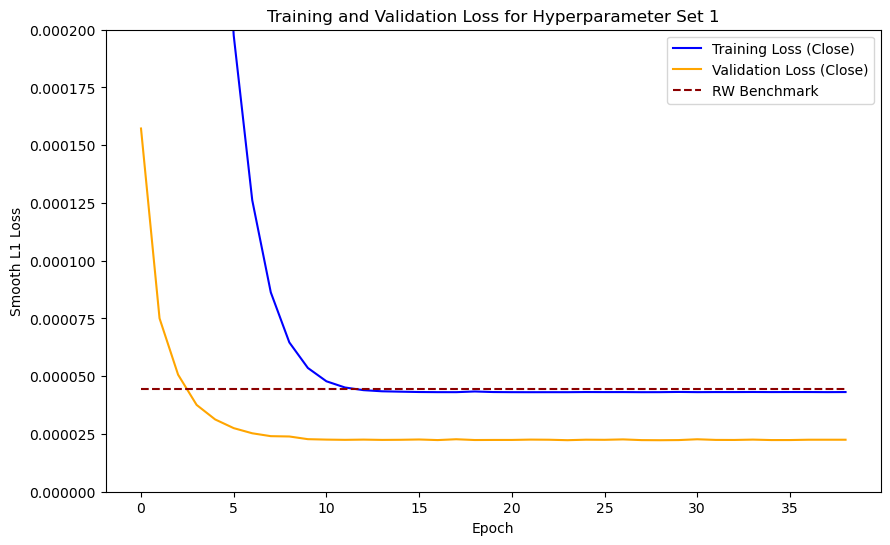

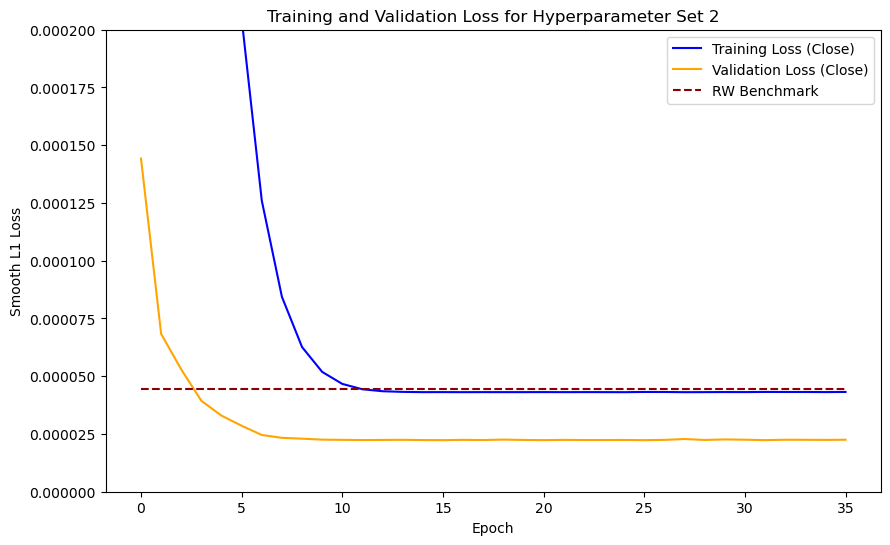

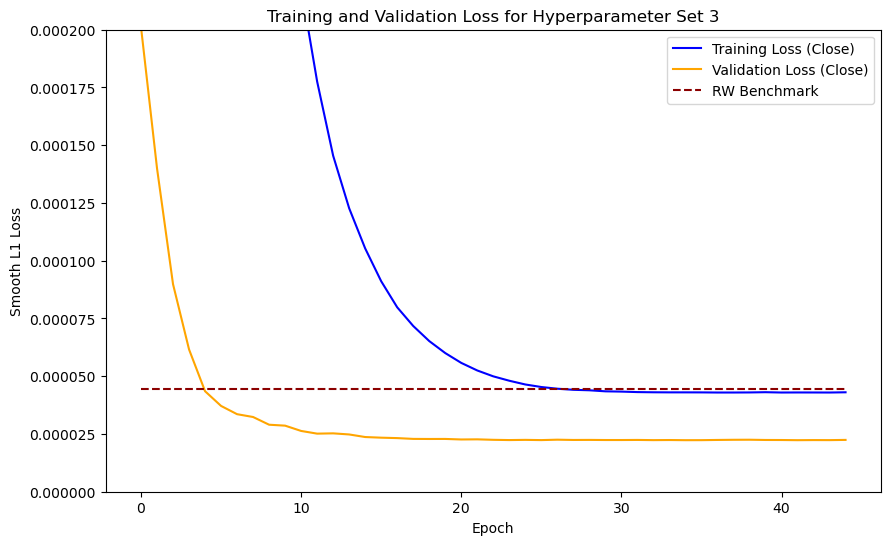

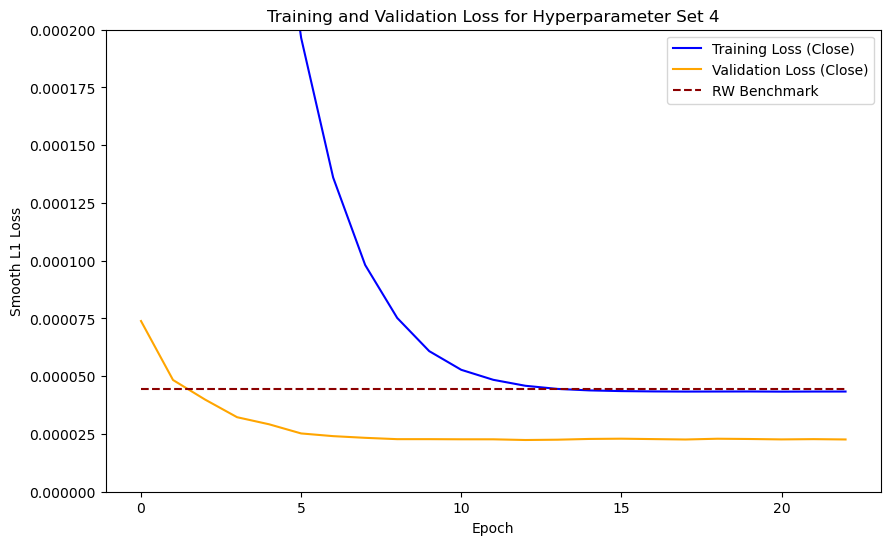

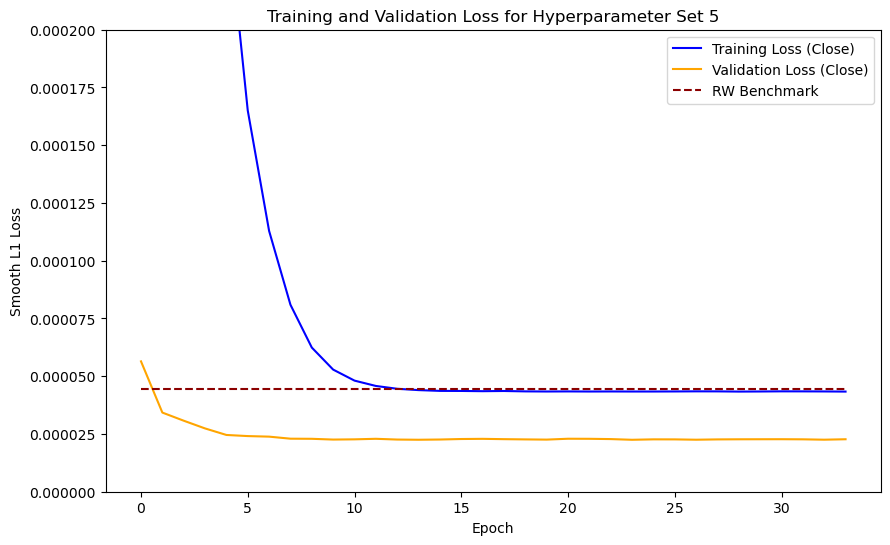

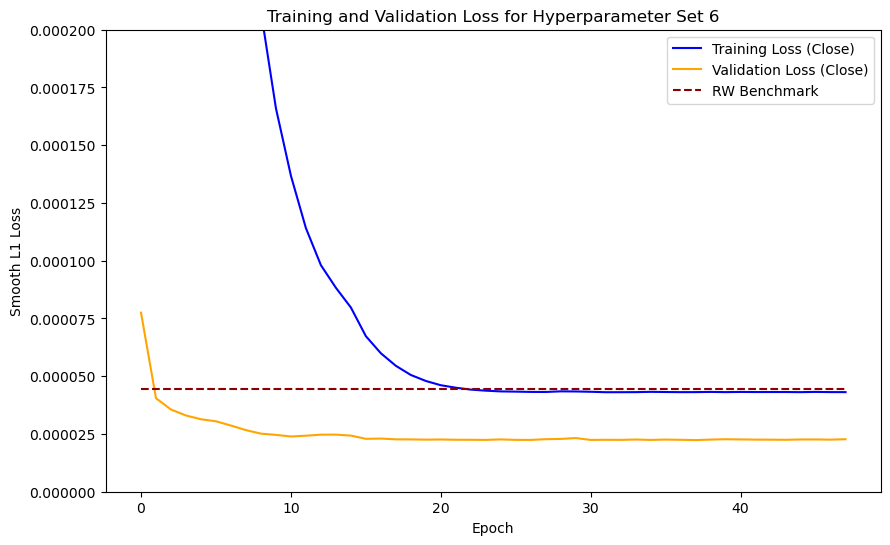

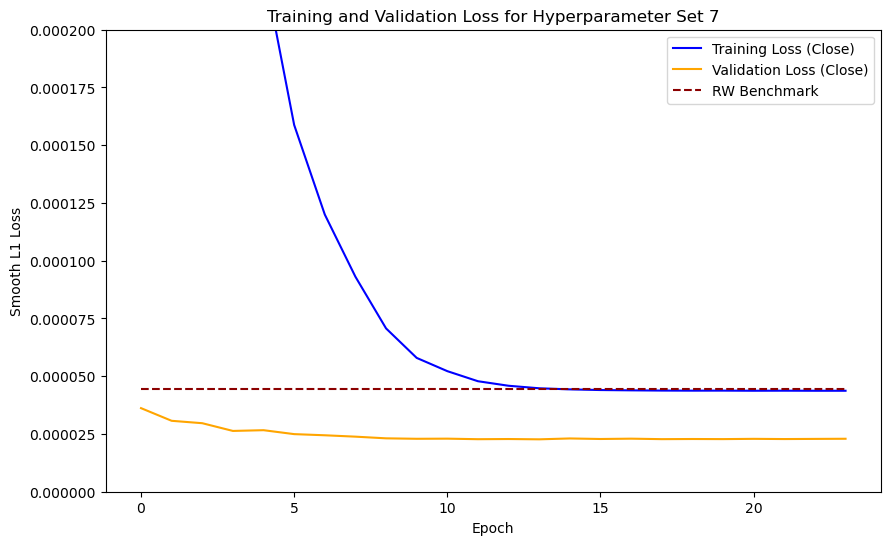

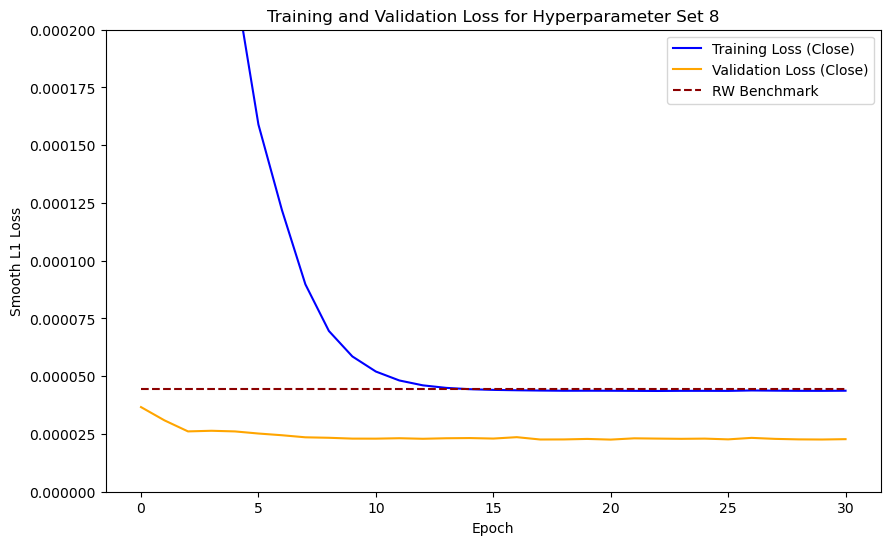

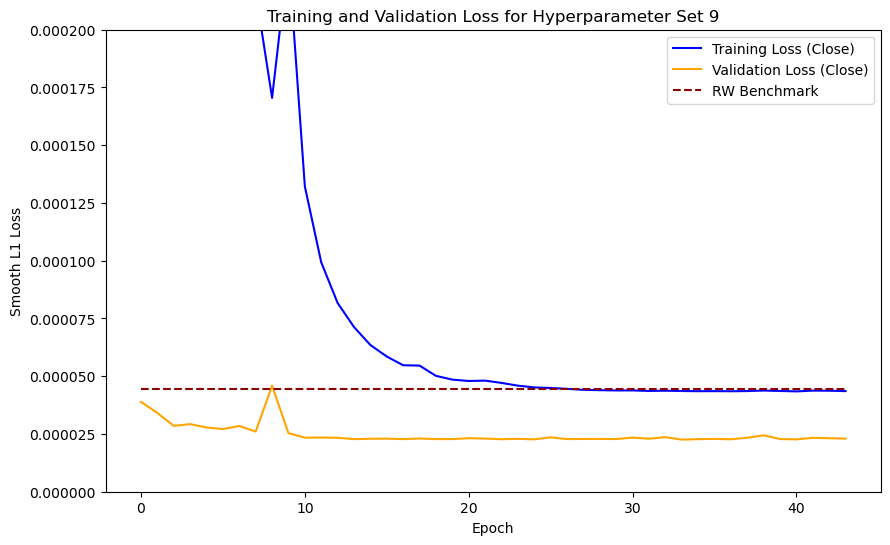

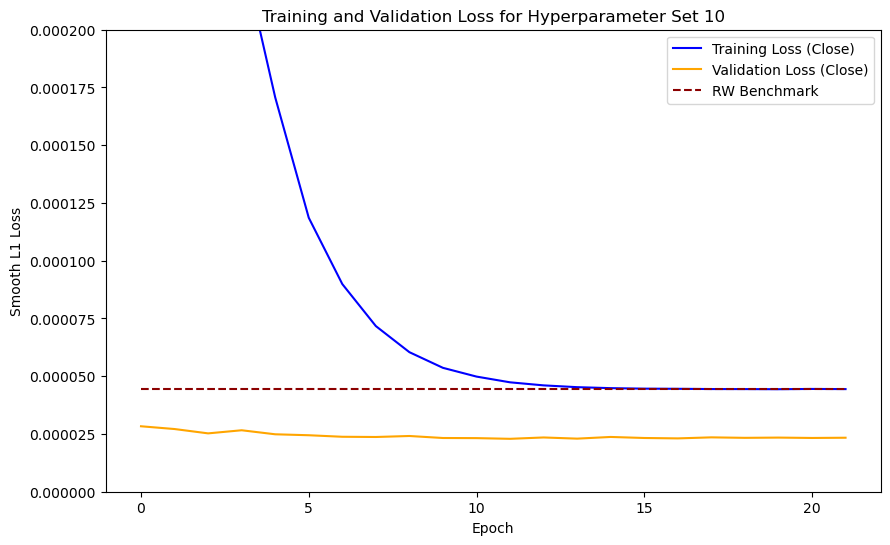

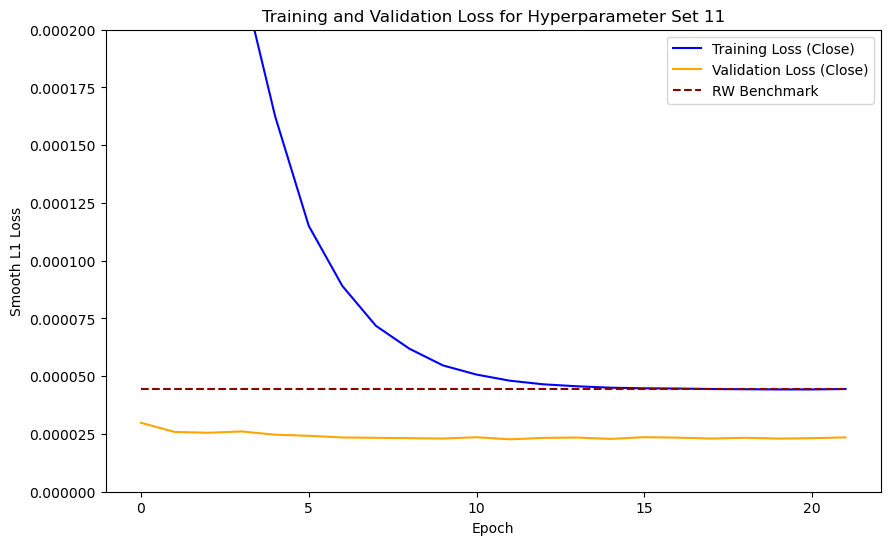

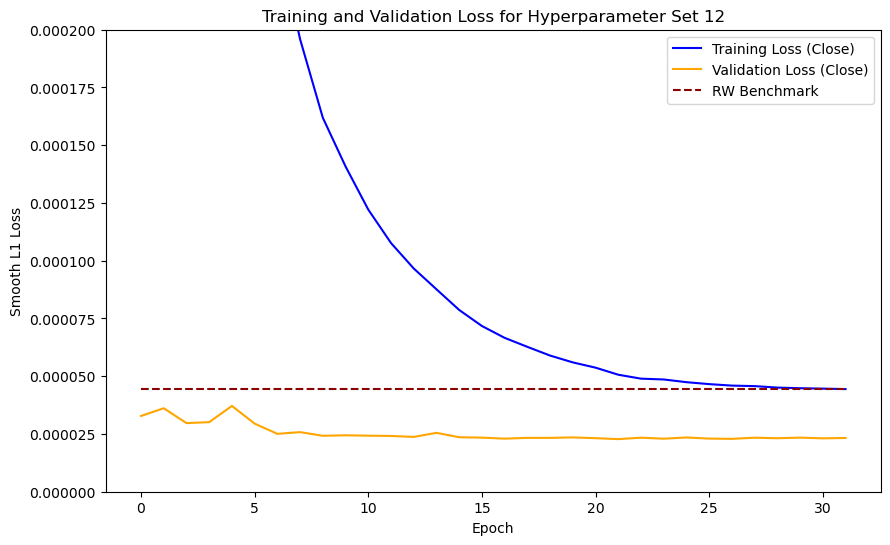

In [27]:
# Plot Performance for Each Hyperparameter Set

#ylim_max = [0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002]
ylim_max = 0.0002

for alt in range(n_alternatives):  # Loop over the 6 hyperparameter alternatives
    train_losses_close = train_losses_close_master[alt]
    val_losses_close = val_losses_close_master[alt]

    # Create RW Benchmark Line for Validation Loss
    RW_benchmark_MSE_valid = model_accuracy_table_RW_valid['MSE'][0]  # Fixed RW Benchmark value
    RW_benchmark_MSE_line = np.full(len(train_losses_close), RW_benchmark_MSE_valid)  # Benchmark line

    # Plot losses and benchmark
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_close, label='Training Loss (Close)', color='blue')
    plt.plot(val_losses_close, label='Validation Loss (Close)', color='orange')
    plt.plot(RW_benchmark_MSE_line, label='RW Benchmark', color='darkred', linestyle='--')
    
    # Formatting
    plt.title(f"Training and Validation Loss for Hyperparameter Set {alt+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Smooth L1 Loss")
    plt.legend()
    plt.ylim([0, ylim_max])  # Adjust based on your loss range
    plt.grid(False)
    plt.show()


In [28]:
# Load the hyperparameter_results from the pickle file
#with open("hyperparameter_results_20M_with_gamma.pkl", "rb") as f:
#    loaded_results = pickle.load(f)

#print("Loaded hyperparameter results:")
#for i, result in enumerate(loaded_results):
#    print(f"Alternative {i+1}: Best Validation Loss: {result['best_val_loss']:.10f}, Gamma: {result['gamma']}")

# load the model that performed best on Closing Price Return prediction
best_result = min(hyperparameter_results, key=lambda x: x["best_val_loss_close"]) #<--- Note this is picking based on closing price accuracy

# Initialize the model with the hyperparameters of the best result
best_model = LSTMModel(
    input_dim=input_dim,
    hidden_dim=best_result["hidden_dim"],
    output_dim=output_dim,
    num_layers=best_result["num_layers"],
    dropout_rate=best_result["dropout_rate"]
).to(device)

# Load the best model state
best_model.load_state_dict(best_result["best_model_state"])

print(f"Loaded the best model with Hidden Dim: {best_result['hidden_dim']}, "
      f"Num Layers: {best_result['num_layers']}, "
      f"Batch Size: {best_result['batch_size']}, "
      f"Validation Loss (Close): {best_result['best_val_loss_close']:.10f}, "
      f"Gamma: {best_result['gamma']}")

model = best_model

# Make predictions

batch_size_predictions = 50

# Function to make predictions in batches
def predict_in_batches(model, data, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i + batch_size].to(device)
            batch_predictions = model(batch_data).cpu().numpy()
            predictions.append(batch_predictions)
            if i % 1000 == 0:
                print(f"Iteration: {i} / {len(data)}")
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
train_predictions = predict_in_batches(model, X_train, batch_size_predictions)
valid_predictions = predict_in_batches(model, X_valid, batch_size_predictions)
test_predictions = predict_in_batches(model, X_test, batch_size_predictions)

# Focus only on 'close' price (index 3)
train_predictions_close_percent = train_predictions[:, :, 3]
valid_predictions_close_percent = valid_predictions[:, :, 3]
test_predictions_close_percent = test_predictions[:, :, 3]

train_predictions_close_prices = np.full((train_predictions_close_percent.shape[0],forecast_horizon),np.nan)
valid_predictions_close_prices = np.full((valid_predictions_close_percent.shape[0],forecast_horizon),np.nan)
test_predictions_close_prices = np.full((test_predictions_close_percent.shape[0],forecast_horizon),np.nan)


train_error_matrix_prices = train_predictions_close_prices.copy
valid_error_matrix_prices = valid_predictions_close_prices.copy
test_error_matrix_prices = test_predictions_close_prices.copy


train_actuals_close_prices = y_train_prices[:,:,3]
valid_actuals_close_prices = y_valid_prices[:,:,3]
test_actuals_close_prices = y_test_prices[:,:,3]

n_cols = X_train_prices.shape[1]

for h in range(forecast_horizon):
    if h == 0:
        train_predictions_close_prices[:,h] = X_train_prices[:,(n_cols-1),3] * (1 + train_predictions_close_percent[:,h])
        valid_predictions_close_prices[:,h] = X_valid_prices[:,(n_cols-1),3] * (1 + valid_predictions_close_percent[:,h])
        test_predictions_close_prices[:,h] = X_test_prices[:,(n_cols-1),3] * (1 + test_predictions_close_percent[:,h])
    else:
        train_predictions_close_prices[:,h] = train_predictions_close_prices[:,h-1] * (1 + train_predictions_close_percent[:,h]) 
        valid_predictions_close_prices[:,h] = valid_predictions_close_prices[:,h-1] * (1 + valid_predictions_close_percent[:,h])
        test_predictions_close_prices[:,h] = test_predictions_close_prices[:,h-1] * (1 + test_predictions_close_percent[:,h])



# Calculate accuracy metrics
accuracy_matrix_train = np.zeros((forecast_horizon,6))
accuracy_matrix_valid = np.zeros((forecast_horizon,6))
accuracy_matrix_test = np.zeros((forecast_horizon,6))


train_horizon_errors = train_predictions_close_prices[:,:] - train_actuals_close_prices[:,:]
valid_horizon_errors = valid_predictions_close_prices[:,:] - valid_actuals_close_prices[:,:]
test_horizon_errors = test_predictions_close_prices[:,:] - test_actuals_close_prices[:,:]

for h in range(forecast_horizon):

    # Compute accuracy metrics for the unnormalized errors
    accuracy_matrix_train[h,0] = np.sqrt(np.mean(train_horizon_errors[:,h]**2))  # RMSE
    accuracy_matrix_train[h,1] = np.mean(train_horizon_errors[:,h]**2)  # MSE
    accuracy_matrix_train[h,2] = np.mean(train_horizon_errors[:,h])  # ME
    accuracy_matrix_train[h,3] = np.mean(np.abs(train_horizon_errors[:,h] / train_actuals_close_prices[:,h]))  # MAPE
    accuracy_matrix_train[h,4] = np.mean(train_horizon_errors[:,h] / train_actuals_close_prices[:,h])  # MPE
    ss_res_train = np.sum(train_horizon_errors[:, h] ** 2)  # Residual sum of squares
    ss_tot_train = np.sum((train_actuals_close_prices[:, h] - np.mean(train_actuals_close_prices[:, h])) ** 2)  # Total sum of squares
    r_squared_train = 1 - (ss_res_train / ss_tot_train) if ss_tot_train != 0 else 0
    accuracy_matrix_train[h, 5] = r_squared_train  # R^2
    
    # Compute accuracy metrics for the unnormalized errors
    accuracy_matrix_valid[h,0] = np.sqrt(np.mean(valid_horizon_errors[:,h]**2))  # RMSE
    accuracy_matrix_valid[h,1] = np.mean(valid_horizon_errors[:,h]**2)  # MSE
    accuracy_matrix_valid[h,2] = np.mean(valid_horizon_errors[:,h])  # ME
    accuracy_matrix_valid[h,3] = np.mean(np.abs(valid_horizon_errors[:,h] / valid_actuals_close_prices[:,h]))  # MAPE
    accuracy_matrix_valid[h,4] = np.mean(valid_horizon_errors[:,h] / valid_actuals_close_prices[:,h])  # MPE
    ss_res_valid = np.sum(valid_horizon_errors[:, h] ** 2)
    ss_tot_valid = np.sum((valid_actuals_close_prices[:, h] - np.mean(valid_actuals_close_prices[:, h])) ** 2)
    r_squared_valid = 1 - (ss_res_valid / ss_tot_valid) if ss_tot_valid != 0 else 0
    accuracy_matrix_valid[h, 5] = r_squared_valid  # R^2
    
    # Compute accuracy metrics for the unnormalized errors
    accuracy_matrix_test[h,0] = np.sqrt(np.mean(test_horizon_errors[:,h]**2))  # RMSE
    accuracy_matrix_test[h,1] = np.mean(test_horizon_errors[:,h]**2)  # MSE
    accuracy_matrix_test[h,2] = np.mean(test_horizon_errors[:,h])  # ME
    accuracy_matrix_test[h,3] = np.mean(np.abs(test_horizon_errors[:,h] / test_actuals_close_prices[:,h]))  # MAPE
    accuracy_matrix_test[h,4] = np.mean(test_horizon_errors[:,h] / test_actuals_close_prices[:,h])  # MPE
    ss_res_test = np.sum(test_horizon_errors[:, h] ** 2)
    ss_tot_test = np.sum((test_actuals_close_prices[:, h] - np.mean(test_actuals_close_prices[:, h])) ** 2)
    r_squared_test = 1 - (ss_res_test / ss_tot_test) if ss_tot_test != 0 else 0
    accuracy_matrix_test[h, 5] = r_squared_test  # R^2

# Create DataFrame for accuracy table
model_accuracy_table_train = pd.DataFrame(
    accuracy_matrix_train, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
) 

model_accuracy_table_valid = pd.DataFrame(
    accuracy_matrix_valid, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
) 

model_accuracy_table_test = pd.DataFrame(
    accuracy_matrix_test, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
) 

print(model_accuracy_table_train)
print(model_accuracy_table_valid)
print(model_accuracy_table_test)

    

Loaded the best model with Hidden Dim: 64, Num Layers: 1, Batch Size: 64, Validation Loss (Close): 0.0000222957, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000 / 38665
Iteration: 34000 / 38665
Iteration: 35000

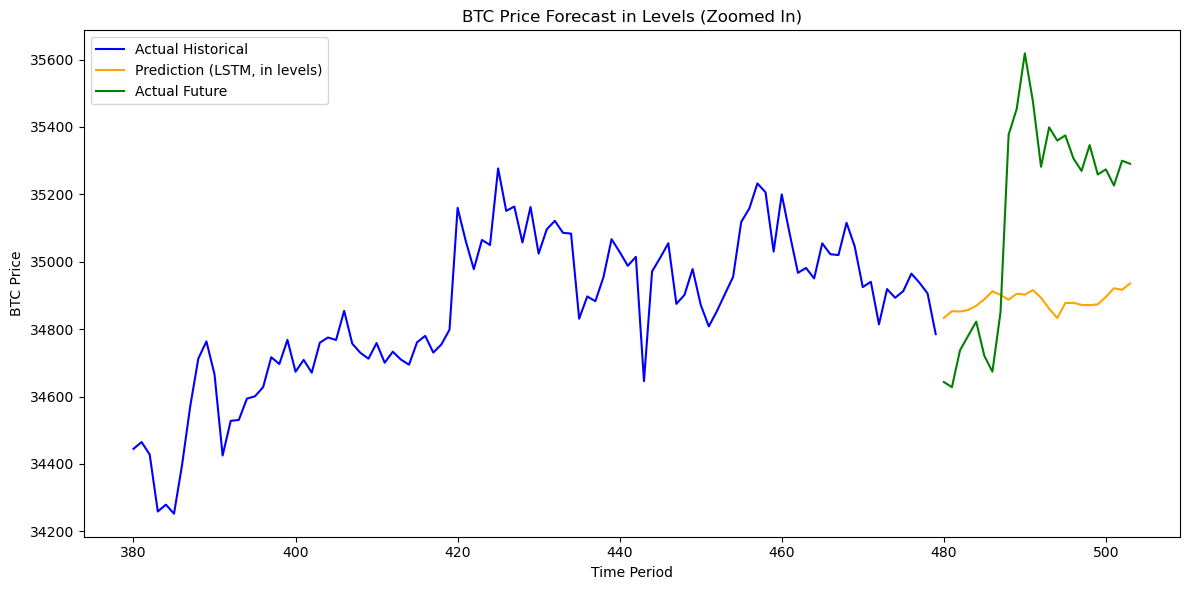

In [29]:
# Parameters
history_zoom = 100  # Number of periods to zoom in on historical data
plot_index = 7000  # Index for the series you're plotting

# Define historical and forecast ranges
history_length = X_test_prices.shape[1]  # Length of the actual historical data (number of time periods in X_test_prices)
forecast_length = test_predictions_close_prices.shape[1]  # Length of the forecast (from predictions)

# Generate x-axis ranges
X_actual = np.arange(history_length - history_zoom, history_length)  # Last N points of actual data
X_forecast = np.arange(history_length, history_length + forecast_length)  # Forecast range

# Select the data for plotting
historical_data = X_test_prices[plot_index, -history_zoom:,3]  # Last `history_zoom` points of historical data
forecast_data = test_predictions_close_prices[plot_index, :]  # Forecasted data
actual_future_data = test_actuals_close_prices[plot_index, :]  # Actual future data for comparison

# Plotting
plt.figure(figsize=(12, 6))

# Historical data
plt.plot(X_actual, historical_data, label="Actual Historical", color="blue")

# Forecasted data
plt.plot(X_forecast, forecast_data, label="Prediction (LSTM, in levels)", color="orange")

# Actual future data
plt.plot(X_forecast, actual_future_data, label="Actual Future", color="green")

# Add labels, title, and legend
plt.xlabel("Time Period")
plt.ylabel("BTC Price")
plt.title("BTC Price Forecast in Levels (Zoomed In)")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
# Determining Directional Accuracy

test_actual_one_period_change = test_actuals_close_prices[:,0] - X_test_prices[:,(n_cols-1),3]
test_actual_one_period_direction = np.sign(test_actual_one_period_change)

test_predictions_one_period_change = test_predictions_close_prices[:,0] - X_test_prices[:,(n_cols-1),3]
test_predictions_one_period_direction = np.sign(test_predictions_one_period_change)

#print(test_actual_one_period_direction)
#print(test_predictions_one_period_direction)

test_predictions_one_period_direction_match = test_predictions_one_period_direction == test_actual_one_period_direction
test_predictions_one_period_direction_match_accuracy = (np.sum(test_predictions_one_period_direction_match,axis=0)/test_predictions_one_period_direction_match.shape[0])

print(f"Directional Accuracy: {test_predictions_one_period_direction_match_accuracy:.4f}%")

# Applying Directional Accuracy Across Horizons

directional_accuracy_horizons = np.full((forecast_horizon,1),np.nan)

for h in range(forecast_horizon):
    test_actual_one_period_change_h = test_actuals_close_prices[:,h] - X_test_prices[:,(n_cols-1),3]
    test_actual_one_period_direction_h = np.sign(test_actual_one_period_change_h)

    test_predictions_one_period_change_h = test_predictions_close_prices[:,h] - X_test_prices[:,(n_cols-1),3]
    test_predictions_one_period_direction_h = np.sign(test_predictions_one_period_change_h)

    test_predictions_one_period_direction_match_h = test_predictions_one_period_direction_h == test_actual_one_period_direction_h
    test_predictions_one_period_direction_match_accuracy_h = (np.sum(test_predictions_one_period_direction_match_h,axis=0)/test_predictions_one_period_direction_match_h.shape[0])
    
    directional_accuracy_horizons[h,0] = test_predictions_one_period_direction_match_accuracy_h
    
#print(directional_accuracy_horizons)

directional_accuracy_horizons_output = directional_accuracy_horizons.flatten()
model_accuracy_table_test["Directional Accuracy"] = directional_accuracy_horizons_output

print(model_accuracy_table_test)

Directional Accuracy: 0.5114%
          RMSE            MSE          ME      MAPE       MPE       R^2  \
0   138.819940   19270.975820   37.097140  0.002949  0.001276  0.999351   
1   191.238252   36572.069219   52.734764  0.004175  0.001824  0.998768   
2   228.798149   52348.592990   42.231593  0.004938  0.001479  0.998238   
3   264.767199   70101.669799   43.696905  0.005746  0.001545  0.997641   
4   298.322482   88996.303464   51.545834  0.006542  0.001828  0.997007   
5   329.236080  108396.396229   69.245394  0.007372  0.002442  0.996355   
6   360.701926  130105.879111   92.664581  0.008265  0.003254  0.995627   
7   379.596471  144093.480810   84.373834  0.008662  0.002981  0.995159   
8   397.227241  157789.481381   66.132159  0.008971  0.002372  0.994701   
9   419.563979  176033.932521   79.123202  0.009635  0.002827  0.994091   
10  436.212826  190281.629154   63.899454  0.009942  0.002321  0.993616   
11  456.938031  208792.363915   73.695255  0.010532  0.002670  0.99299

In [31]:
# Simple Trading Rule --- Set Up Combined Data

starting_index = X_train.shape[1]


predictions_combined = np.concatenate([
    train_predictions_close_prices,
    valid_predictions_close_prices,
    test_predictions_close_prices
], axis=0)

actuals_combined = np.concatenate([
    X_train_prices[:, :, 3],  # Closing prices
    X_valid_prices[:, :, 3],
    X_test_prices[:, :, 3]
], axis=0)

# Confirm the shape of the combined arrays
print(f"Predictions Combined Shape: {predictions_combined.shape}")
print(f"Actuals Combined Shape: {actuals_combined.shape}")

n_periods = predictions_combined.shape[0]

# Simple Trading Rule --- Run Trading Rule

rule_horizon = 0 # 1-step ahead

starting_money = 1000
coin_holdings = 0
cash_history = []
total_wealth_history = []
buy_and_hold = []

tol = 0

for t in range(n_periods):
    
    price_t = actuals_combined[t, (actuals_combined.shape[1]-1)]
    prediction_t_plus_h = predictions_combined[t,rule_horizon]
        
    if t == 0:
        cash = starting_money
        total_wealth = starting_money
        coin_0 = starting_money / price_t
        
    if coin_holdings == 0 and prediction_t_plus_h > price_t + tol:
        coin_holdings = cash / price_t
        cash = 0
        total_wealth = coin_holdings * price_t
        
    if coin_holdings > 0 and prediction_t_plus_h > price_t + tol:
        total_wealth = coin_holdings * price_t

    if coin_holdings > 0 and prediction_t_plus_h < price_t + tol:
        cash = coin_holdings * price_t
        coin_holdings = 0
        total_wealth = cash

    if coin_holdings > 0 and prediction_t_plus_h < price_t + tol:
        total_wealth = cash
        
    # if t == (n_periods-1):
    #     cash = coin_holdings * price_t
    #     coin_holdings = 0
    #     total_wealth = cash
        
    cash_history.append(cash)
    # print(t)
    total_wealth_history.append(total_wealth)
    buy_and_hold.append(coin_0 * price_t)
        
    if t % 1000 == 0:
        print(f"Period: {t} / {n_periods}, Cash: {cash:.2f}, Coin Holdings: {coin_holdings:.4f}, Total Wealth: {total_wealth:.2f}, Price_t: {price_t:.2f}, E(Price_t+1): {prediction_t_plus_h:.2f}")

print(f"Final Cash: {cash:.2f}")


Predictions Combined Shape: (55237, 24)
Actuals Combined Shape: (55237, 480)
Period: 0 / 55237, Cash: 0.00, Coin Holdings: 0.2279, Total Wealth: 1000.00, Price_t: 4388.48, E(Price_t+1): 4394.60
Period: 1000 / 55237, Cash: 0.00, Coin Holdings: 0.2279, Total Wealth: 1249.83, Price_t: 5484.86, E(Price_t+1): 5492.41
Period: 2000 / 55237, Cash: 0.00, Coin Holdings: 0.2279, Total Wealth: 2255.90, Price_t: 9899.99, E(Price_t+1): 9905.46
Period: 3000 / 55237, Cash: 0.00, Coin Holdings: 0.2317, Total Wealth: 3395.94, Price_t: 14659.57, E(Price_t+1): 14683.01
Period: 4000 / 55237, Cash: 0.00, Coin Holdings: 0.2317, Total Wealth: 2556.07, Price_t: 11034.00, E(Price_t+1): 11043.04
Period: 5000 / 55237, Cash: 0.00, Coin Holdings: 0.2317, Total Wealth: 1690.38, Price_t: 7297.00, E(Price_t+1): 7305.60
Period: 6000 / 55237, Cash: 0.00, Coin Holdings: 0.2317, Total Wealth: 1971.87, Price_t: 8512.15, E(Price_t+1): 8522.17
Period: 7000 / 55237, Cash: 0.00, Coin Holdings: 0.2317, Total Wealth: 1426.00, Pr

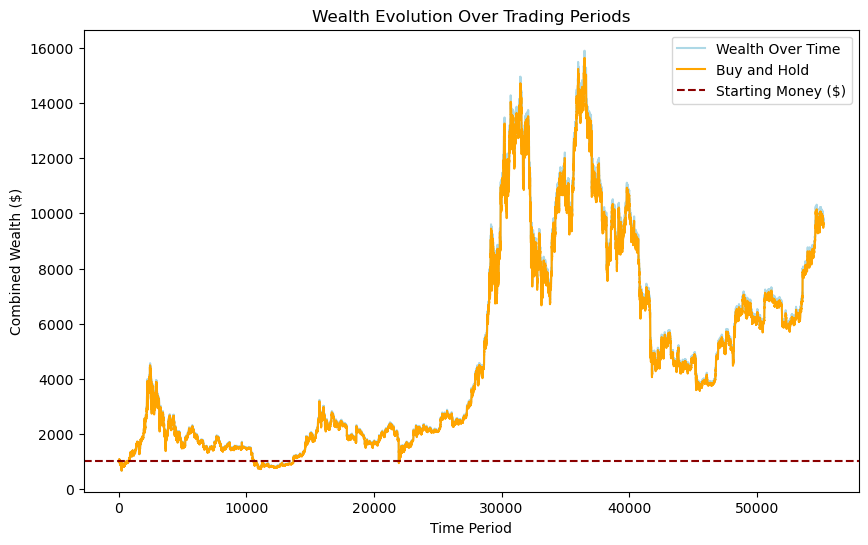

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(total_wealth_history, label="Wealth Over Time", color="lightblue")
plt.plot(buy_and_hold, label="Buy and Hold", color="orange")
plt.axhline(y=starting_money, color="darkred", linestyle="--", label="Starting Money ($)")
plt.xlabel("Time Period")
plt.ylabel("Combined Wealth ($)")
plt.title("Wealth Evolution Over Trading Periods")
plt.legend()
plt.grid(False)
plt.show()

In [120]:
# RL Approach to Trading Strategy Design (Deep Q-Learning)

# Defining a PyTorch DQN model
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    

# Create a Function that will use current price and price predictions to generate states
def generate_state(predictions, prices, t):
    """
    Args:
    - predictions: A numpy array of shape (T, H, 4) containing OHLC predictions.
    - prices: A numpy array of shape (T, 4) containing actual OHLC prices.
    - t: Current time index.
    - horizon: Forecast horizon.
    
    Returns:
    - state: A numpy array representing the state.
    
    Note:
    - Need to mask future periods to avoid look-ahead bias
    """
    horizon = predictions.shape[1]
    
    current_price = prices[t,:] # Note: this will stop future prices getting into states
    future_predictions = predictions[t,:,:] # Note: this will stop predictions at future time periods getting into states
    
    # Predicted Price Changes
    predicted_price_changes = future_predictions - current_price
    
    # Calculate Predicted Percent Returns 
    predicted_percent_returns = (future_predictions - current_price) / current_price
    
    # Combine predicted price differences and percentage returns
    state = np.concatenate([predicted_price_changes.flatten(), predicted_percent_returns.flatten(), current_price])
    return state







In [121]:
def train_dqn(predictions, prices, state_dim, action_dim, train_episodes, replay_buffer, gamma=0.95, batch_size=64):
    dqn = DQN(state_dim, action_dim).to(device)
    optimizer = optim.Adam(dqn.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.1

    for episode in range(train_episodes):
        for t in range(len(features) - 1):
            state = generate_state(predictions, prices, t)
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

            # Choose action using epsilon-greedy
            if np.random.rand() < epsilon:
                action = random.choice([0, 1, 2])  # 0: hold, 1: buy, 2: sell
            else:
                with torch.no_grad():
                    q_values = dqn(state_tensor)
                    action = torch.argmax(q_values).item()

            # Reward and next state
            reward = compute_reward(action, prices, t)
            next_state = generate_state(predictions, prices, t + 1)
            done = (t == len(prices) - 2)

            # Store experience
            replay_buffer.append((state, action, reward, next_state, done))

            # Sample a batch for training
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.tensor(states, dtype=torch.float32).to(device)
                actions = torch.tensor(actions, dtype=torch.long).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)

                q_values = dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = dqn(next_states).max(1)[0]
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = loss_fn(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update epsilon
            epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return dqn

# Reward function
def compute_reward(action, prices, t):
    price_t = prices[t, 3]  # Use the Close price
    price_t_next = prices[t + 1, 3]
    if action == 1:  # Buy
        return price_t_next - price_t
    elif action == 2:  # Sell
        return price_t - price_t_next
    return 0  # Hold

def evaluate_dqn(dqn, predictions, prices):
    """
    Evaluate a trained DQN model on a validation set.
    
    Args:
    - dqn: Trained DQN model.
    - predictions: Validation predictions, shape (T, H, 4).
    - prices: Validation prices, shape (T, 4).
    - horizon: Forecast horizon.
    
    Returns:
    - performance: Cumulative profit or another performance metric.
    """
    
    horizon = predictions.shape[1]
    
    cash = 1000  # Starting cash
    coin_holdings = 0
    portfolio_value = []  # To track portfolio value over time

    for t in range(len(prices) - 1):
        # Generate state
        state = generate_state(predictions, prices, t)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

        # Get action from DQN
        with torch.no_grad():
            q_values = dqn(state_tensor)
            action = torch.argmax(q_values).item()

        # Get current and next prices (using Close price)
        price_t = prices[t, 3]
        price_t_next = prices[t + 1, 3]

        # Execute action
        if action == 1:  # Buy
            if cash > 0:
                coin_holdings += cash / price_t
                cash = 0
        elif action == 2:  # Sell
            if coin_holdings > 0:
                cash += coin_holdings * price_t
                coin_holdings = 0

        # Calculate portfolio value
        total_value = cash + coin_holdings * price_t
        portfolio_value.append(total_value)

    # Final portfolio value
    final_value = cash + coin_holdings * prices[-1, 3]
    portfolio_value.append(final_value)

    # Performance metric (e.g., cumulative profit or Sharpe ratio)
    returns = np.diff(portfolio_value) / portfolio_value[:-1]
    performance = np.sum(returns)  # Cumulative profit; replace with Sharpe ratio if needed

    return performance

def evaluate_best_model(dqn, predictions, prices):
    """
    Evaluate the best trained DQN model on the entire dataset.
    
    Args:
    - dqn: Trained DQN model.
    - predictions: Full dataset predictions, shape (T, H, 4).
    - prices: Full dataset prices, shape (T, 4).
    - horizon: Forecast horizon.
    
    Returns:
    - portfolio_value: List of portfolio values over time.
    - buy_and_hold: List of portfolio values for a buy-and-hold strategy.
    """
    horizon = predictions.shape[1]

    
    # Initial conditions
    cash = 1000  # Starting cash
    coin_holdings = 0
    portfolio_value = []  # Track portfolio values over time

    # Buy-and-hold strategy
    initial_price = prices[0, 3]  # Initial Close price
    buy_and_hold = [(cash / initial_price) * prices[t, 3] for t in range(len(prices))]

    # Run the DQN model on the entire dataset
    for t in range(len(prices) - 1):
        # Generate state
        state = generate_state(predictions, prices, t)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

        # Get action from the DQN model
        with torch.no_grad():
            q_values = dqn(state_tensor)
            action = torch.argmax(q_values).item()

        # Get current price (Close price)
        price_t = prices[t, 3]

        # Execute action
        if action == 1:  # Buy
            if cash > 0:
                coin_holdings += cash / price_t
                cash = 0
        elif action == 2:  # Sell
            if coin_holdings > 0:
                cash += coin_holdings * price_t
                coin_holdings = 0

        # Track total portfolio value
        total_value = cash + coin_holdings * price_t
        portfolio_value.append(total_value)

    # Final portfolio value (liquidate holdings)
    final_value = cash + coin_holdings * prices[-1, 3]
    portfolio_value.append(final_value)

    return portfolio_value, buy_and_hold


In [122]:
# Hyperparameter search
n_alternatives = 3
hidden_sizes = [12,64,128]
best_DQN_model = None
best_performance = -float('inf')

n_col_prices = X_train_prices.shape[1]
train_predictions_DQN = train_predictions[:,:,:4]
train_prices_DQN = X_train_prices[:,(n_col_prices-1),:4]
valid_predictions_DQN = valid_predictions[:,:,:4]
valid_prices_DQN = X_valid_prices[:,(n_col_prices-1),:4]

all_predictions = np.concatenate([
    train_predictions[:,:,:4],
    valid_predictions[:,:,:4],
    test_predictions[:,:,:4]
    ], axis=0)

all_prices = np.concatenate([
    X_train_prices[:,(n_col_prices-1),:4],
    X_valid_prices[:,(n_col_prices-1),:4],
    X_test_prices[:,(n_col_prices-1),:4]
    ], axis=0)


dim_T = train_predictions_DQN.shape[0] # T
dim_H = train_predictions_DQN.shape[1] # H
dim_P = 4
state_dim = (dim_H * dim_P * 2) + dim_P # (Horizons x num_series x 2 for prices and return) +  the price_t data put into state

action_dim = 3 # Hold, Buy, Sell


In [123]:
for alt in range(n_alternatives):
    print(f"Training DQN with hidden size: {hidden_sizes[alt]}")
    dqn = train_dqn(train_predictions_DQN, train_prices_DQN, state_dim, action_dim, train_episodes=2000, replay_buffer=deque(maxlen=10000), gamma=0.99)
    # Evaluate on validation set
    performance = evaluate_dqn(dqn, valid_predictions_DQN, valid_prices_DQN)
    if performance > best_performance:
        best_performance = performance
        best_DQN_model = dqn

# Run the best model on the entire dataset
portfolio_value, buy_and_hold = evaluate_best_model(best_DQN_model, all_predictions, all_prices)

Training DQN with hidden size: 12
Training DQN with hidden size: 64
Training DQN with hidden size: 128


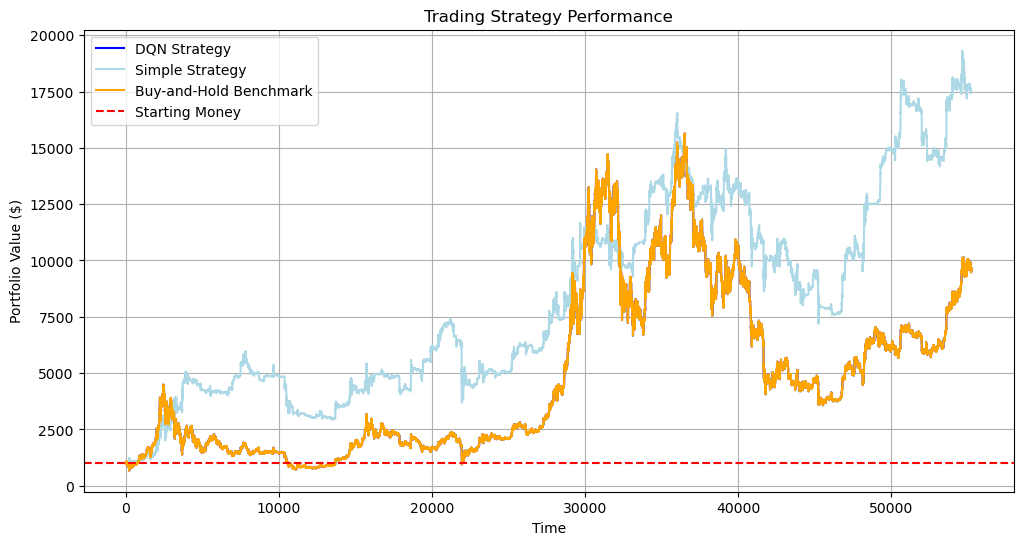

In [124]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label="DQN Strategy", color="blue")
plt.plot(total_wealth_history, label="Simple Strategy", color="lightblue")
plt.plot(buy_and_hold, label="Buy-and-Hold Benchmark", color="orange")
plt.axhline(y=starting_money, color="red", linestyle="--", label="Starting Money")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.title("Trading Strategy Performance")
plt.legend()
plt.grid(True)
plt.show()

In [125]:
n_trials = 5
portfolio_results = []
buy_and_hold_results = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")
    best_performance = -float('inf')
    best_DQN_model = None

    # Train DQN with hyperparameter search
    for alt in range(n_alternatives):
        print(f"Training DQN with hidden size: {hidden_sizes[alt]}")
        dqn = train_dqn(
            train_predictions_DQN, 
            train_prices_DQN, 
            state_dim, 
            action_dim, 
            train_episodes=1000, 
            replay_buffer=deque(maxlen=10000), 
            gamma=0.99
        )
        # Evaluate on validation set
        performance = evaluate_dqn(dqn, valid_predictions_DQN, valid_prices_DQN)
        if performance > best_performance:
            best_performance = performance
            best_DQN_model = dqn

    # Evaluate best model on the entire dataset
    portfolio_value, buy_and_hold = evaluate_best_model(
        best_DQN_model, all_predictions, all_prices
    )
    portfolio_results.append(portfolio_value)
    buy_and_hold_results.append(buy_and_hold)

# Average results across trials
avg_portfolio_value = np.mean(portfolio_results, axis=0)
avg_buy_and_hold = np.mean(buy_and_hold_results, axis=0)


Trial 1/5
Training DQN with hidden size: 12
Training DQN with hidden size: 64
Training DQN with hidden size: 128
Trial 2/5
Training DQN with hidden size: 12
Training DQN with hidden size: 64
Training DQN with hidden size: 128
Trial 3/5
Training DQN with hidden size: 12
Training DQN with hidden size: 64
Training DQN with hidden size: 128
Trial 4/5
Training DQN with hidden size: 12
Training DQN with hidden size: 64
Training DQN with hidden size: 128
Trial 5/5
Training DQN with hidden size: 12
Training DQN with hidden size: 64
Training DQN with hidden size: 128


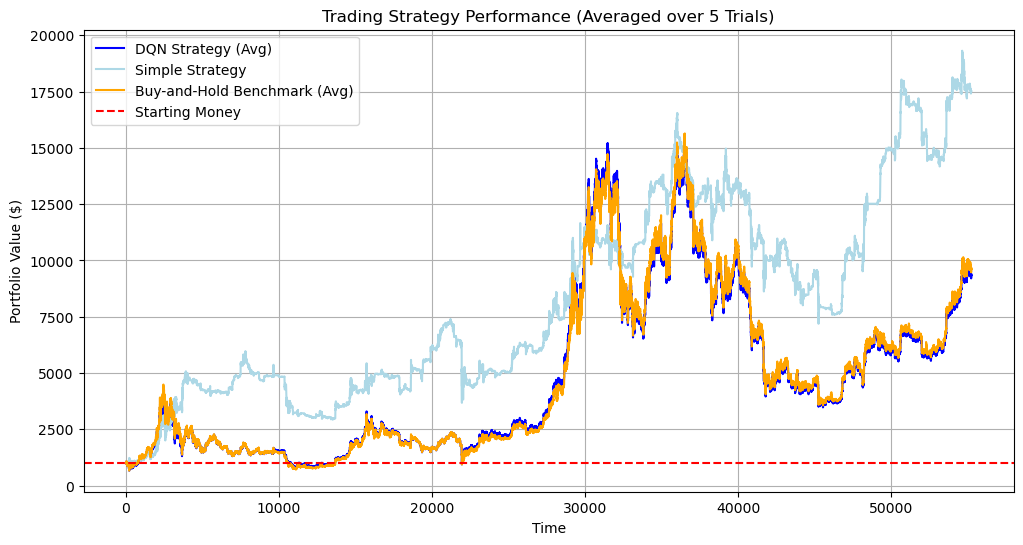

In [126]:

# Plot the averaged results
plt.figure(figsize=(12, 6))
plt.plot(avg_portfolio_value, label="DQN Strategy (Avg)", color="blue")
plt.plot(total_wealth_history, label="Simple Strategy", color="lightblue")
plt.plot(avg_buy_and_hold, label="Buy-and-Hold Benchmark (Avg)", color="orange")
plt.axhline(y=starting_money, color="red", linestyle="--", label="Starting Money")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.title(f"Trading Strategy Performance (Averaged over {n_trials} Trials)")
plt.legend()
plt.grid(True)
plt.show()

In [127]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio for a series of returns.

    Args:
    - returns: A numpy array or list of periodic returns.
    - risk_free_rate: The risk-free rate of return (default is 0.0).

    Returns:
    - sharpe_ratio: The Sharpe Ratio for the given returns.
    """
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_deviation = np.std(excess_returns)

    # Handle division by zero for cases with zero standard deviation
    if std_deviation == 0:
        return 0.0

    sharpe_ratio = mean_excess_return / std_deviation
    return sharpe_ratio


In [129]:
DQN_percent_returns = np.diff(portfolio_value) / portfolio_value[:-1]  # DQN strategy returns
simple_strategy_percent_returns = np.diff(total_wealth_history) / total_wealth_history[:-1]  # Simple strategy returns
buy_and_hold_percent_returns = np.diff(buy_and_hold) / buy_and_hold[:-1]  # Buy-and-hold returns

# Calculate Sharpe Ratios
sharpe_DQN = calculate_sharpe_ratio(DQN_percent_returns, risk_free_rate = 0.0)
sharpe_simple = calculate_sharpe_ratio(simple_strategy_percent_returns, risk_free_rate = 0.0)
sharpe_buy_and_hold = calculate_sharpe_ratio(buy_and_hold_percent_returns, risk_free_rate = 0.0)

print(f"Sharpe Ratio (DQN Strategy): {sharpe_DQN:.4f}")
print(f"Sharpe Ratio (Simple Strategy): {sharpe_simple:.4f}")
print(f"Sharpe Ratio (Buy and Hold): {sharpe_buy_and_hold:.4f}")

Sharpe Ratio (DQN Strategy): 0.0094
Sharpe Ratio (Simple Strategy): 0.0116
Sharpe Ratio (Buy and Hold): 0.0091
